In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import squarify

In [42]:
# campaign_desc = pd.read_csv('Data/campaign_desc.csv')
# campaign_table = pd.read_csv('Data/campaign_table.csv')
# causal_data = pd.read_csv('Data/causal_data.csv')
# coupon = pd.read_csv('Data/coupon.csv')
# coupon_redempt = pd.read_csv('Data/coupon_redempt.csv')
# hh_demographic = pd.read_csv('Data/hh_demographic.csv')
# product = pd.read_csv('Data/product.csv')
transaction_data = pd.read_csv('Data/transaction_data.csv')

In [43]:
td = transaction_data.head(10)
print(td)

   household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   
5           2375  26984851516    1      826249         2         1.98   
6           2375  26984851516    1     1043142         1         1.57   
7           2375  26984851516    1     1085983         1         2.99   
8           2375  26984851516    1     1102651         1         1.89   
9           2375  26984851516    1     6423775         1         2.00   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631

In [44]:
max_date = transaction_data['DAY'].max()
max_date = max_date + 1

In [45]:
rfm_customers = transaction_data.groupby(['household_key']).agg({
    'DAY': 'max',
    'household_key': 'count',
    'SALES_VALUE': 'sum'
})

In [46]:
rfm_customers['DAY'] = max_date - rfm_customers['DAY']

In [47]:
rfm_customers

,DAY,household_key,SALES_VALUE
household_key,,,
1,6,1727,4330.16
2,44,714,1954.34
3,9,922,2653.21
4,85,301,1200.11
5,9,222,779.06
...,...,...,...
2496,29,1489,4339.66
2497,12,1962,7111.98
2498,2,859,2601.60


In [48]:
rfm_customers.rename(columns = {'DAY': 'Recency',
                                'household_key':'Frequency',
                                'SALES_VALUE':'MonetaryValue'
}, inplace = True)


In [49]:
rfm_customers

,Recency,Frequency,MonetaryValue
household_key,,,
1,6,1727,4330.16
2,44,714,1954.34
3,9,922,2653.21
4,85,301,1200.11
5,9,222,779.06
...,...,...,...
2496,29,1489,4339.66
2497,12,1962,7111.98
2498,2,859,2601.60


The data should meet assumptions where the variables are not skewed and have the same mean and variance. 

Here are the visualizations of each variable,

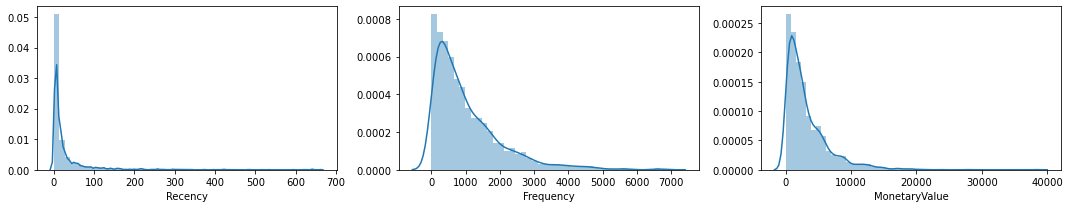

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(rfm_customers['Recency'], ax=ax[0])
sns.distplot(rfm_customers['Frequency'], ax=ax[1])
sns.distplot(rfm_customers['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()

In [51]:
quantiles = rfm_customers.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,MonetaryValue
0.25,2.0,325.0,970.74
0.50,7.0,734.0,2157.75
0.75,21.0,1454.5,4413.32


In [52]:
##  RFM Segmentation ----
RFM_Segment = rfm_customers.copy()
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
RFM_Segment['R_Quartile'] = RFM_Segment['Recency'].apply(R_Class, args=('Recency',quantiles,))
RFM_Segment['F_Quartile'] = RFM_Segment['Frequency'].apply(FM_Class, args=('Frequency',quantiles,))
RFM_Segment['M_Quartile'] = RFM_Segment['MonetaryValue'].apply(FM_Class, args=('MonetaryValue',quantiles,))
RFM_Segment['RFMClass'] = RFM_Segment.R_Quartile.map(str) \
                            + RFM_Segment.F_Quartile.map(str) \
                            + RFM_Segment.M_Quartile.map(str)

In [53]:
RFM_Segment

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass
household_key,,,,,,,
1,6,1727,4330.16,3,4,3,343
2,44,714,1954.34,1,2,2,122
3,9,922,2653.21,2,3,3,233
4,85,301,1200.11,1,1,2,112
5,9,222,779.06,2,1,1,211
...,...,...,...,...,...,...,...
2496,29,1489,4339.66,1,4,3,143
2497,12,1962,7111.98,2,4,4,244
2498,2,859,2601.60,4,3,3,433


Now lets identify the number of unique segments

In [54]:
RFM_count_unique = RFM_Segment.groupby('RFMClass')['RFMClass'].nunique()
print(RFM_count_unique.sum())

42


Calculating the sum of the RFM values instead of the mean as the sum is much easier to segment

In [55]:
RFM_Segment['RFM_Score'] = RFM_Segment[['R_Quartile','F_Quartile','M_Quartile']].sum(axis=1)
print(RFM_Segment['RFM_Score'].head())

household_key
1    10
2     5
3     8
4     4
5     4
Name: RFM_Score, dtype: int64


# Segmentation Using the RFM Scores

In [56]:
def customer_segment(df):
    if (df['RFMClass'] >= 442 or (df['RFM_Score'] >= 9)) :
        return 'Best Customers - Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 7) and (df['M_Quartile'] == 4)):
        return 'Champions Spenders'
    elif ((df['RFM_Score'] >= 6) and (df['F_Quartile'] >= 2) and (df['R_Quartile'] >=2)):
        return 'Loyal Customers'
    elif ((df['RFMClass'] >= 221) or (df['RFM_Score'] >= 6)):
        return 'Potential Loyalists'
    elif (((df['RFMClass'] >= 121) and (df['R_Quartile'] == 1)) or df['RFM_Score'] == 5):
        return 'Needs Attention'
    elif ((df['RFM_Score'] >= 4) and (df['R_Quartile'] == 1)):
        return 'Hibernating - Almost Lost'
    else:
        return 'Lost Customers'
    
    

**Can't Loose Them** 
The customers who have been recent, frequent and have spend a decent amount in the retail store

**Champions Spenders**
The customers who have spend a huge amount of money and have a decent Frequency and Recency score

**Loyal Customers**
The customers who has an averge score in all the three parameters such as Frequency, Recency and Monetary Value

**Potential Loyalists**
The customers who might not have spend much on the retailer but but have an averge recency and frequency score

**Needs Attention**
The customers who have an average frequency score but their recency score has been pretty low

**Almost Lost**
Almost Lost are the customers who might have either a decent frequency score but their recency score is poor

**Lost Customers**
The customers who have a poor recency, frequency and Monetary Value score are the lost customers and there is no point in investing to trying to get them back

In [57]:
RFM_Segment['RFMClass'] = RFM_Segment.RFMClass.apply(lambda x: int(x))
RFM_Segment['Customer Segment'] = RFM_Segment.apply(customer_segment, axis=1)

In [58]:
RFM_Segment

,Recency,Frequency,MonetaryValue,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFM_Score,Customer Segment
household_key,,,,,,,,,
1,6,1727,4330.16,3,4,3,343,10,Best Customers - Can't Loose Them
2,44,714,1954.34,1,2,2,122,5,Needs Attention
3,9,922,2653.21,2,3,3,233,8,Loyal Customers
4,85,301,1200.11,1,1,2,112,4,Hibernating - Almost Lost
5,9,222,779.06,2,1,1,211,4,Lost Customers
...,...,...,...,...,...,...,...,...,...
2496,29,1489,4339.66,1,4,3,143,8,Potential Loyalists
2497,12,1962,7111.98,2,4,4,244,10,Best Customers - Can't Loose Them
2498,2,859,2601.60,4,3,3,433,10,Best Customers - Can't Loose Them


In [59]:
rfm_seg_agg = RFM_Segment.groupby('Customer Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'],
}).round(2)
# Print the aggregated dataset
print(rfm_seg_agg)

                                  Recency Frequency MonetaryValue      
                                     mean      mean          mean count
Customer Segment                                                       
Best Customers - Can't Loose Them    5.09   1898.63       5977.13  1014
Champions Spenders                  69.80   1203.90       5317.15    10
Hibernating - Almost Lost           57.60    269.20       1150.59    20
Lost Customers                      88.21    143.60        430.95   437
Loyal Customers                      8.87    658.92       1904.28   595
Needs Attention                     60.16    460.98       1397.63   156
Potential Loyalists                 23.20    471.55       1421.90   268


In [60]:
rfm_level_ag = pd.DataFrame(rfm_seg_agg)
rfm_level_ag = rfm_level_ag.reset_index()
rfm_level_ag

Customer Segment Recency Frequency MonetaryValue      
                                        mean      mean          mean count
0  Best Customers - Can't Loose Them    5.09   1898.63       5977.13  1014
1                 Champions Spenders   69.80   1203.90       5317.15    10
2          Hibernating - Almost Lost   57.60    269.20       1150.59    20
3                     Lost Customers   88.21    143.60        430.95   437
4                    Loyal Customers    8.87    658.92       1904.28   595
5                    Needs Attention   60.16    460.98       1397.63   156
6                Potential Loyalists   23.20    471.55       1421.90   268

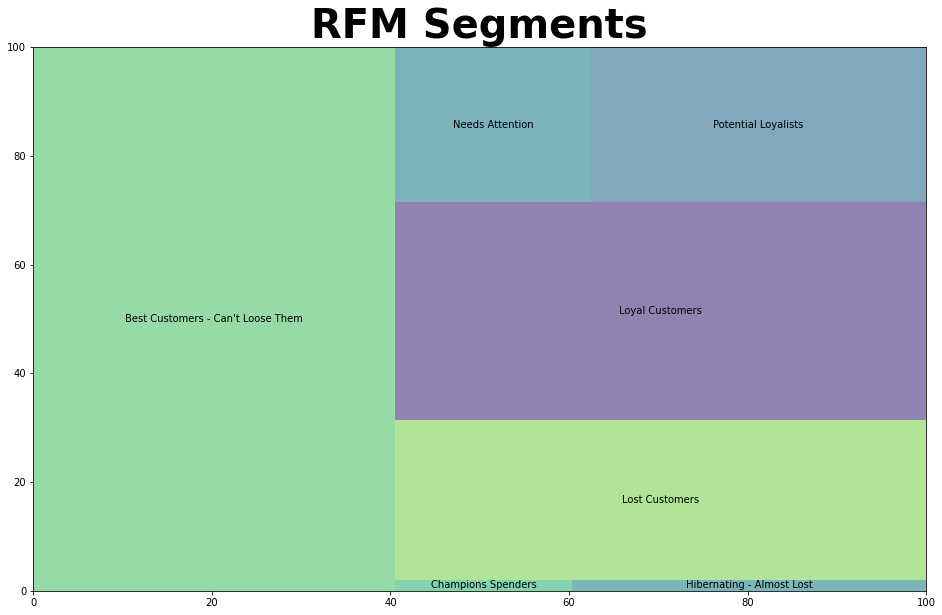

In [61]:
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes=rfm_level_ag['MonetaryValue', 'count'], 
              label=rfm_level_ag['Customer Segment'], alpha=.6 )
plt.title("RFM Segments",fontsize=40,fontweight="bold")
plt.axis('on')
plt.show()

# K-Means Clustering

In [62]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm_customers[x], ax=ax[0,0])
    sns.distplot(np.log(rfm_customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm_customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm_customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
#     print(rfm_customers[x].skew().round(2))
#     print(np.log(rfm_customers[x]).skew().round(2))
#     print(np.sqrt(rfm_customers[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm_customers[x])[0]).skew().round(2))

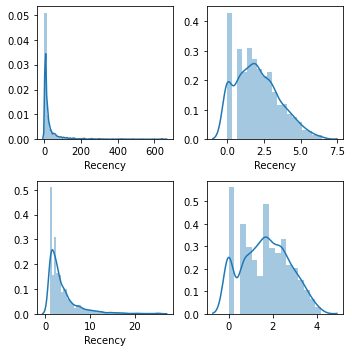

In [63]:
analyze_skewness('Recency')

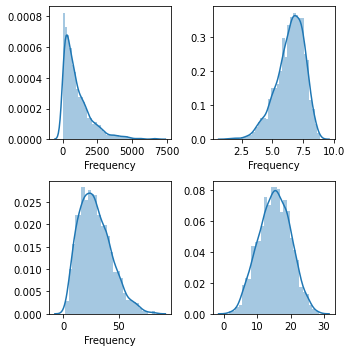

In [64]:
analyze_skewness('Frequency')

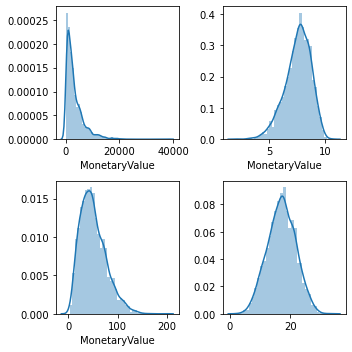

In [65]:
analyze_skewness('MonetaryValue')

Based on that visualization, it shows that the variables with box-cox transformation shows a more symmetrical form rather than the other transformations.

In [66]:
# Set the Numbers
customers = pd.DataFrame()
customers["Recency"] =  stats.boxcox(rfm_customers['Recency'])[0]
customers["Frequency"] = stats.boxcox(rfm_customers['Frequency'])[0]
customers["MonetaryValue"] = stats.boxcox(rfm_customers['MonetaryValue'])[0]
customers.tail()

,Recency,Frequency,MonetaryValue
2495,2.655749,18.772310,20.389495
2496,2.081505,20.272997,22.893859
2497,0.658992,16.046837,18.029655
2498,1.014464,17.518589,19.227634
2499,1.254126,18.821692,21.548999


In [67]:
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers)
customers_normalized = scaler.transform(customers) #rfm_customers
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[0. 0. 0.]
[1. 1. 1.]


In [68]:
print(customers_normalized)

[[-0.08602231  0.9195358   0.69752187]
 [ 1.16126734 -0.00597126 -0.08047488]
 [ 0.1982428   0.24307649  0.20480027]
 ...
 [-0.94711401  0.17267502  0.1859726 ]
 [-0.6130085   0.48490945  0.44683374]
 [-0.38775167  0.76136468  0.95231321]]


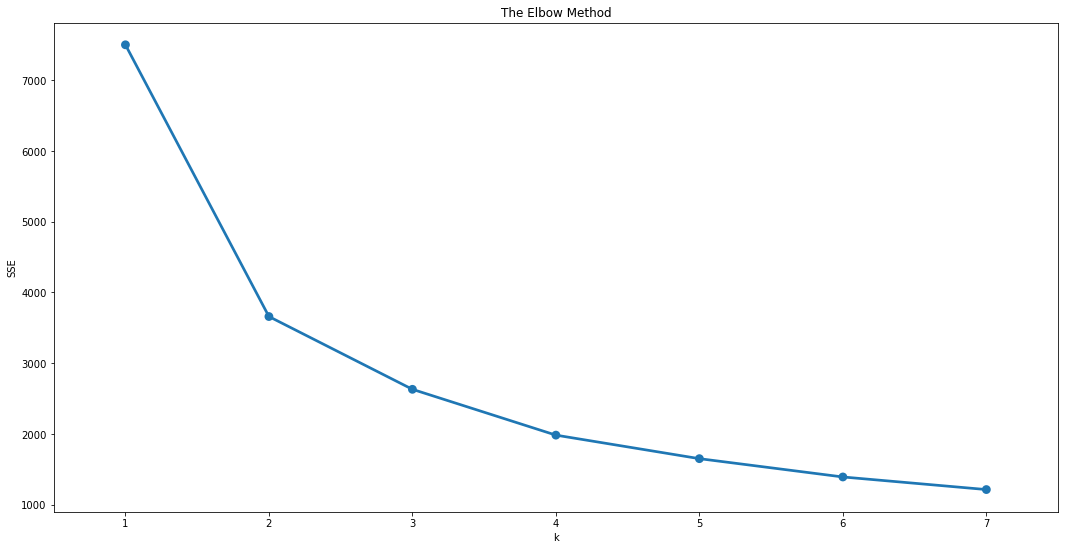

In [69]:
from sklearn.cluster import KMeans

sse = {}
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.figure(figsize=(18,9))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


In [75]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(2500,)

In [76]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          0.76     13.64         15.64   538
1          2.82      9.16         11.27   546
2          2.26     15.75         17.67   731
3          0.83     20.77         22.56   685

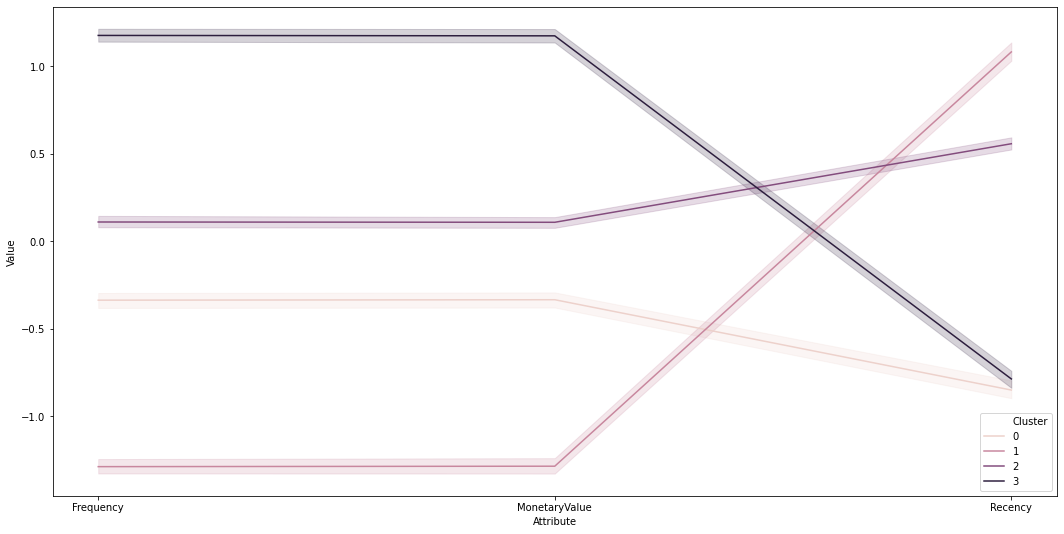

In [77]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
plt.figure(figsize = (18,9))
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

Calculate relative importance of each attribute Now we will calculate the relative importance of the RFM values within each cluster.

In [78]:
cluster_avg = customers.groupby(['Cluster']).mean()
population_avg = customers.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(1)

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.1,-0.1,-0.5
1,NaN,-0.4,-0.3,0.7
2,NaN,0.0,0.0,0.4
3,NaN,0.4,0.3,-0.5


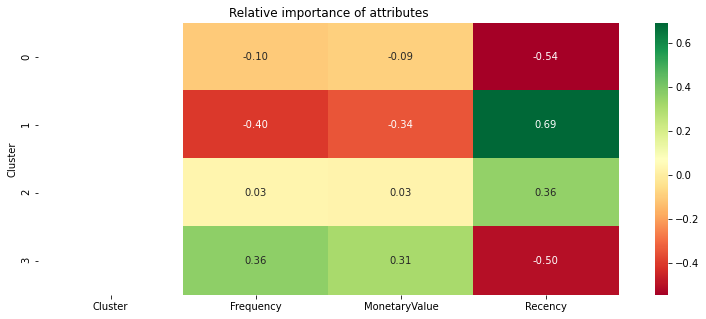

In [79]:
plt.figure(figsize=(13, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()


We can see that every cluster places different emphasis on every feature:

## Cluster 0
This has lowest frequency mean and low Monetary Value mean but lowest Recency mean. This segment of customers are lost

## Cluster 1 

This has the lowest frequency and pretty lowest Monetary Value mean but the recency mean is really high. This segment of customers might have just started purchasing in the retailer and the business can invest market low prices to make them more interested

## Cluster 2
This cluster have an average Frequency and average Monetary Value but a high recency mean. We need to keep them engaged to make them buy more products

## Cluster 3
This cluster of customers have good Frequency mean, good Monetary Value mean and poor Recency mean. We need to do something to not lose them as they were interested in the business until a few months ago
